# Feature Extraction

To prepare the dataset for training, you will extract features from each image using the following pipeline.

- **Dominant Colors**
  - The 5 dominant colors of an image are extracted using the K-Means clustering algorithm.
  - Each pixel in the image is then replaced with the nearest dominant color.
  - Optionally, the spatial arrangement of pixels is shuffled.

- **Pretrained Model**
  - MobileNetV3-specific preprocessing is applied to the quantized image.
  - The resulting image is passed through the convolutional backbone and the global average pooling.
  - The output is flattened to obtain a fixed-length (960) feature vector.

- **Feature Caching**
    - The extracted feature vectors are precomputed for all images in the dataset and stored on disk.

Each step is explained below. Code snippets are provided as a starting point for your implementation.

## Dominant Colors

The first step is to process an image so that only the 5 dominant colors are retained. Download the following files and put them in your working directory.
 - [mosaic.py](code/mosaic.py)
 - [kmeans.py](code/kmeans.py)
 - [color.py](code/color.py)

Import the class `BuildMosaic` from `mosaic.py`. This is a PyTorch transform that expects the input to be a tensor of shape `(3, H, W)` or `(B, 3, H, W)`, where `B` is the batch size, `H` is the height, and `W` is the width of each image. The image pixels are expected to be in the RGB color space with `uint8` values in the range [0, 255] or `float32` values in the range [0, 1]. The output is a tensor of the same shape as the input.

The following code demonstrates how to build a minimal PyTorch pipeline with `BuildMosaic`.

In [1]:
import sys
sys.path.append('code')

In [2]:
from torchvision.transforms import v2
from mosaic import BuildMosaic

process_fn = v2.Compose([
    v2.ToImage(),
    BuildMosaic(),
])

The figure below shows the original image on the left and the transformed image on the right.

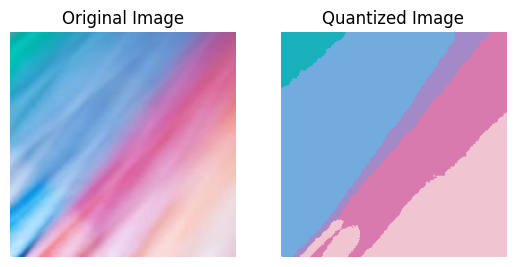

In [3]:
import PIL
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)

orig_image = PIL.Image.open('.data/images/Blue-Pink/000002.jpg')

out_image = process_fn(orig_image)

plt.subplot(1, 2, 1)
plt.imshow(orig_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(out_image.permute(1, 2, 0))
plt.title('Quantized Image')
plt.axis('off')

plt.show()

## Pretrained Model

The second step is to extract features from the quantized image using a pretrained MobileNetV3. The following code demonstrates how to import the model and define a pipeline that includes `BuildMosaic` and the MobileNetV3 preprocessing.

In [4]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.transforms import v2
from mosaic import BuildMosaic

# Load the model in evaluation mode
weights = MobileNet_V3_Large_Weights.DEFAULT
preprocess = weights.transforms()
mobilenet = mobilenet_v3_large(weights=weights)
mobilenet.eval()

# Modify the preprocessing pipeline
preprocess_adapted = v2.Compose([
    v2.ToImage(),
    BuildMosaic(shuffle=False), # or =True to shuffle the pixels
    preprocess,
])

The feature extraction is performed as follows for a batch of images.

In [ ]:
image_batch = torch.randint(0, 255, (10, 3, 300, 300), dtype=torch.uint8)
image_batch = preprocess_adapted(image_batch)

with torch.inference_mode():
    output = mobilenet.features(image_batch)
    output = mobilenet.avgpool(output)
    output = torch.flatten(output, 1)
    
print('Input size:', *image_batch.shape)
print('Output size:', *output.shape)

Input size: 10 3 224 224
Output size: 10 960


## Feature Caching

The final step is to extract features from all images in the dataset and store them on disk. 
- Load the dataset with `ImageFolder` using `preprocess_adapted` as the transform.
- Create a `DataLoader` to iterate over the dataset.
- Loop over the dataset to extract features. Store them and the corresponding labels in two separate lists.
- After the loop, convert the lists to PyTorch tensors and save them to disk using `torch.save`.

Afterwards, you can load features and labels with `torch.load` to create a `TensorDataset`.

```python
import torch
from torch.utils.data import TensorDataset

features = torch.load('.data/features.pt')
labels   = torch.load('.data/labels.pt')

feature_ds = TensorDataset(features, labels)
```